In [1]:
# imports
import pandas as pd
import numpy as np
import time

# seed
np.random.seed(0)

In [2]:
# where data is located
!ls ./drive/MyDrive/Thesis\ Workspace/Notebooks/data/set-2
DATA_PATH = "./drive/MyDrive/Thesis Workspace/Notebooks/data/set-2"

tweets	users


### NOTE
User data is not used!

In [4]:
# load tweet data
df_tweet_bot = pd.concat(
    [
        pd.read_csv(f'{DATA_PATH}/tweets/social_spambots_1.csv'),
        pd.read_csv(f'{DATA_PATH}/tweets/social_spambots_2.csv'),
        pd.read_csv(f'{DATA_PATH}/tweets/social_spambots_3.csv')
    ]
).reset_index(drop=True)

df_tweet_naive = pd.read_csv(f'{DATA_PATH}/tweets/tweets.csv', header=None, escapechar='\\')
df_tweet_naive.drop(12, axis=1, inplace=True)
df_tweet_naive.columns = df_tweet_bot.columns
print('Shapes', df_tweet_bot.shape, df_tweet_naive.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shapes (3457133, 25) (8377522, 25)


## Features

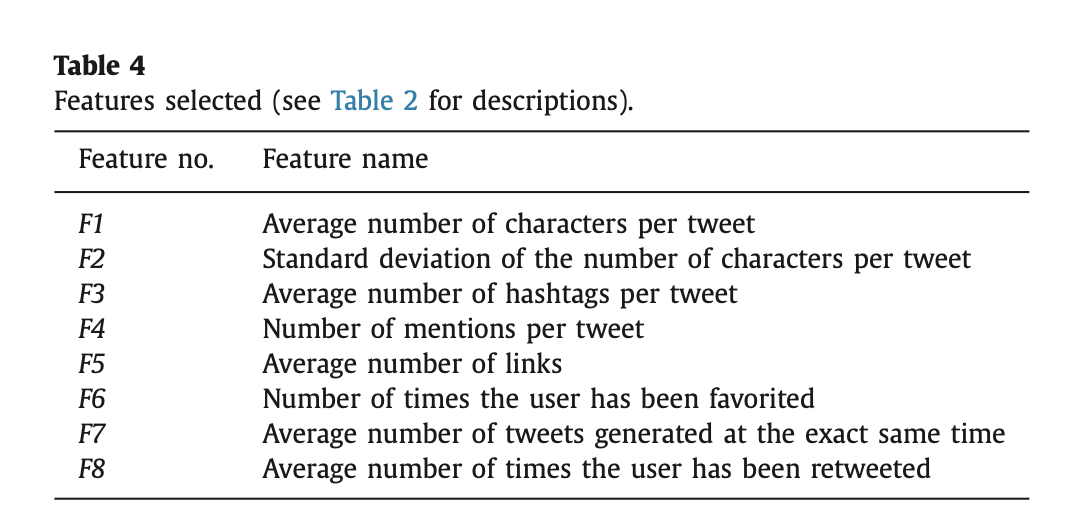

### Notes on features
- F7: what does it mean exact same time?
  - -> Let's just say this is same 'timestamp'
- **Also**, Looking at the features, we can see that user info is not used, only the derived info from user tweet history!

In [188]:
def feature_extraction(df):
  df_grouped = df.groupby('user_id')
  df_return = pd.DataFrame()

  character_per_tweet = pd.DataFrame({
      'text_len': df['text'].astype(str).apply(lambda x: len(x)) 
  })
  character_per_tweet['user_id'] = df['user_id']
  character_per_tweet = character_per_tweet.groupby('user_id')['text_len']
  df_return['avg_characters'] = character_per_tweet.mean()
  df_return['std_characters'] = character_per_tweet.std()

  df_return['avg_hashtags'] = df_grouped['num_hashtags'].mean()
  df_return['avg_mentions'] = df_grouped['num_mentions'].mean()
  df_return['avg_urls'] = df_grouped['num_urls'].mean()
  df_return['favorites_received'] = df_grouped['favorite_count'].sum()
  df_return['retweets_received'] = df_grouped['retweet_count'].mean()

  df_return['avg_tweet_same_time'] =df.groupby(['user_id', 'timestamp'])['timestamp'].agg(['count']).groupby('user_id').mean()
  return df_return

feature_time = time.time()
df_bot, df_naive = [feature_extraction(df) for df in [df_tweet_bot, df_tweet_naive]]
end_feature_time = time.time()
print('Time: ', end_feature_time - feature_time)
print('shapes: ', df_bot.shape, df_naive.shape)
df_bot.head()


Time:  41.45703887939453
shapes:  (4912, 8) (3394, 8)


,avg_characters,std_characters,avg_hashtags,avg_mentions,avg_urls,favorites_received,retweets_received,avg_tweet_same_time
user_id,,,,,,,,
16195340,98.029920,37.936346,0.377545,0.190623,0.719001,437,0.194941,1.005895
16282004,60.562248,46.763043,0.002794,0.003726,0.868053,23,0.008693,1.000932
16740486,94.849587,32.945352,0.155372,0.576860,0.343802,84,482.842975,1.003317
17132768,90.990078,25.093100,0.640310,0.017984,0.038450,1872,2.408992,1.000000
18013384,91.341674,31.425261,0.114612,0.068273,0.494285,125,1.559778,1.001857


### Check and cleanup

In [189]:
df_bot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4912 entries, 16195340 to 2525273432
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   avg_characters       4912 non-null   float64
 1   std_characters       4912 non-null   float64
 2   avg_hashtags         4912 non-null   float64
 3   avg_mentions         4912 non-null   float64
 4   avg_urls             4912 non-null   float64
 5   favorites_received   4912 non-null   int64  
 6   retweets_received    4912 non-null   float64
 7   avg_tweet_same_time  4912 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 345.4 KB


In [190]:
df_bot.apply(lambda x: x.unique())


avg_characters         [98.029919802591, 60.56224774914623, 94.849586...
std_characters         [37.936345855457716, 46.76304338362559, 32.945...
avg_hashtags           [0.3775447254780999, 0.0027941633033219497, 0....
avg_mentions           [0.1906230721776681, 0.003725551071095933, 0.5...
avg_urls               [0.7190006169031462, 0.8680533995653523, 0.343...
favorites_received     [437, 23, 84, 1872, 125, 16, 107, 291, 8, 382,...
retweets_received      [0.19494139420111042, 0.008692952499223843, 48...
avg_tweet_same_time    [1.005895128762023, 1.0009322560596643, 1.0033...
dtype: object

In [191]:
df_bot.isin([np.nan, np.inf, -np.inf]).sum()


avg_characters         0
std_characters         0
avg_hashtags           0
avg_mentions           0
avg_urls               0
favorites_received     0
retweets_received      0
avg_tweet_same_time    0
dtype: int64

In [192]:
df_naive.isin([np.nan, np.inf, -np.inf]).sum()


avg_characters         0
std_characters         0
avg_hashtags           0
avg_mentions           0
avg_urls               0
favorites_received     0
retweets_received      0
avg_tweet_same_time    0
dtype: int64

### Save to csv

In [193]:
save_path = "./drive/MyDrive/Thesis Workspace/Notebooks/data/sb15-set2/"
df_naive.to_csv(save_path + 'naive.csv', index = False)
df_bot.to_csv(save_path + 'bot.csv', index = False)